In [250]:
import sys
import os
import sklearn
import cv2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
#去除没有必要的警告
import warnings
warnings.filterwarnings(action="ignore",message="internal gelsd")
# 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号, 注意['SimHei']对应这句不行
np.random.seed(42)
tf.random.set_seed(42)

In [251]:
from PIL import Image
import numpy as np
import os

image_folder = './dataset/train'

# 获取文件夹中所有图片的路径
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')]

# 加载所有图片
images = []
for path in image_paths:
    if "SP5" in path:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (100,100))
        images.append(image)

# 将所有图片转换成Numpy数组
images_array = np.array([np.array(image) for image in images])


In [252]:
print(images_array.shape)

(150, 100, 100)


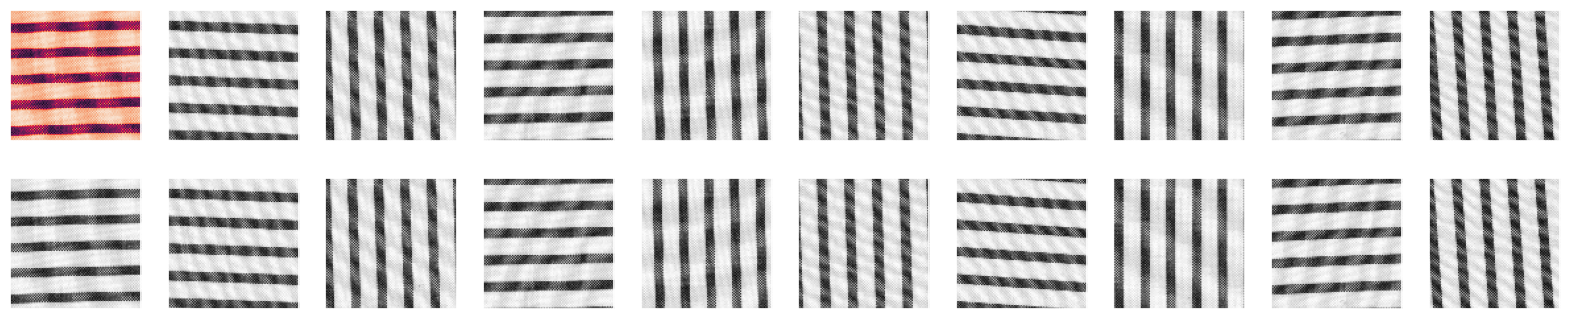

In [253]:
def show_images(decode_images, x_test):
    """
    plot the images.
    :param decode_images: the images after decoding
    :param x_test: testing data
    :return:
    """
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        ax.imshow(x_test[i].reshape(100, 100))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        ax.imshow(decode_images[i].reshape(100, 100))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
show_images(images_array, images_array)

In [254]:
import numpy as np

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras import initializers,regularizers,constraints
import matplotlib.pyplot as plt

np.random.seed(33)   # random seed，to reproduce results.

ENCODING_DIM_INPUT = 10000
ENCODING_DIM_LAYER1 = 128
ENCODING_DIM_LAYER2 = 128
ENCODING_DIM_LAYER3 = 64
ENCODING_DIM_OUTPUT = 64
EPOCHS = 500
BATCH_SIZE = 100
NOISE_FACTOR = 0.5


In [255]:
def train(x_train):

    # input placeholder
    input_image = Input(shape=(ENCODING_DIM_INPUT, ))

    # encoding layer
    # *****this code is changed compared with Autoencoder, adding the activity_regularizer to make the input sparse.
    encode_layer1 = Dense(ENCODING_DIM_LAYER1, activation='relu', activity_regularizer=regularizers.l1(10e-6))(input_image)
    # ******************************
    encode_layer2 = Dense(ENCODING_DIM_LAYER2, activation='relu')(encode_layer1)
    encode_layer3 = Dense(ENCODING_DIM_LAYER3, activation='relu')(encode_layer2)
    encode_output = Dense(ENCODING_DIM_OUTPUT)(encode_layer3)

    # decoding layer
    decode_layer1 = Dense(ENCODING_DIM_LAYER3, activation='relu')(encode_output)
    decode_layer2 = Dense(ENCODING_DIM_LAYER2, activation='relu')(decode_layer1)
    decode_layer3 = Dense(ENCODING_DIM_LAYER1, activation='relu')(decode_layer2)
    decode_output = Dense(ENCODING_DIM_INPUT, activation='tanh')(decode_layer3)

    # build autoencoder, encoder
    autoencoder = Model(inputs=input_image, outputs=decode_output)
    encoder = Model(inputs=input_image, outputs=encode_output)

    # compile autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')

    # training
    autoencoder.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

    return encoder, autoencoder

In [256]:
def add_noise(x_train, x_test):
    """
    add noise.
    :return:
    """
    x_train_noisy = x_train + NOISE_FACTOR * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_test_noisy = x_test + NOISE_FACTOR * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

    x_train_noisy = np.clip(x_train_noisy, 0., 1.)     # limit into [0, 1]
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)   # limit into [0, 1]

    return x_train_noisy, x_test_noisy

def plot_representation(encode_images, y_test):
    """
    plot the hidden result.
    :param encode_images: the images after encoding
    :param y_test: the label.
    :return:
    """
    # test and plot
    plt.scatter(encode_images[:, 0], encode_images[:, 1], c=y_test, s=3)
    plt.colorbar()
    plt.show()

In [257]:
def show_images(decode_images, x_test):
    """
    plot the images.
    :param decode_images: the images after decoding
    :param x_test: testing data
    :return:
    """
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        ax.imshow(x_test[i].reshape(100, 100))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        ax.imshow(decode_images[i].reshape(100, 100))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

(150, 100, 100)
(150, 100, 100)


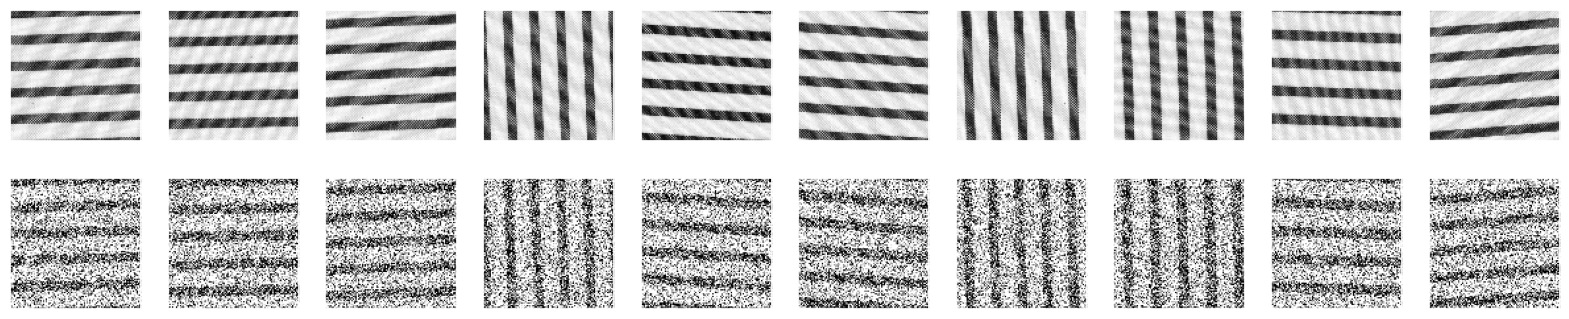

Epoch 1/500
2/2 [==============================] - 1s 30ms/step - loss: 0.5929
Epoch 2/500
2/2 [==============================] - 0s 28ms/step - loss: 0.4190
Epoch 3/500
2/2 [==============================] - 0s 28ms/step - loss: 0.1637
Epoch 4/500
2/2 [==============================] - 0s 27ms/step - loss: 0.1331
Epoch 5/500
2/2 [==============================] - 0s 29ms/step - loss: 0.1417
Epoch 6/500
2/2 [==============================] - 0s 29ms/step - loss: 0.1441
Epoch 7/500
2/2 [==============================] - 0s 32ms/step - loss: 0.1448
Epoch 8/500
2/2 [==============================] - 0s 29ms/step - loss: 0.1450
Epoch 9/500
2/2 [==============================] - 0s 29ms/step - loss: 0.1452
Epoch 10/500
2/2 [==============================] - 0s 30ms/step - loss: 0.1452
Epoch 11/500
2/2 [==============================] - 0s 32ms/step - loss: 0.1452
Epoch 12/500
2/2 [==============================] - 0s 32ms/step - loss: 0.1452
Epoch 13/500
2/2 [==============================]

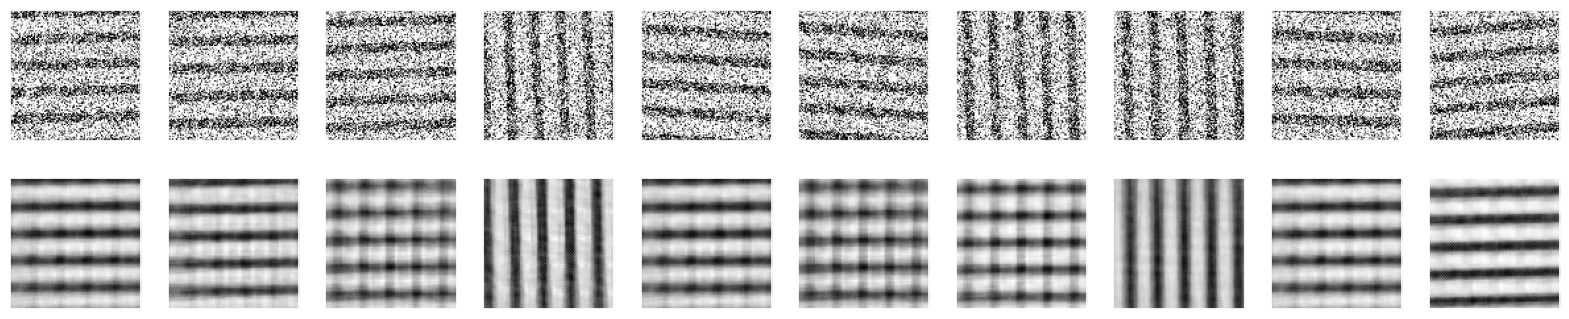

In [258]:
if __name__ == '__main__':
    # Step1： load data  x_train: (60000, 28, 28), y_train: (60000,) x_test: (10000, 28, 28), y_test: (10000,)
    print(images_array.shape)
    np.random.shuffle(images_array)
    print(images_array.shape)
    x_train, x_test = images_array[:150] , images_array[:150]

    # Step2: normalize
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    # Step3: reshape data, x_train: (60000, 784), x_test: (10000, 784), one row denotes one sample.
    x_train = x_train.reshape((x_train.shape[0], -1))
    x_test = x_test.reshape((x_test.shape[0], -1))

    # Step4: add noisy
    x_train_noisy, x_test_noisy = add_noise(x_train, x_test)
    # show the contrast before noising and after noising.
    show_images(x_test_noisy, x_test)

    # Step5： train
    encoder,autoencoder = train(x_train=x_train)

    # test and plot
    encode_images = encoder.predict(x_test_noisy)

    # show images
    decode_images = autoencoder.predict(x_test_noisy)
    show_images(decode_images, x_test_noisy)

0.31807187


C:\Users\11516\AppData\Local\Temp\ipykernel_7800\1991224745.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored,


(0.0, 0.5)

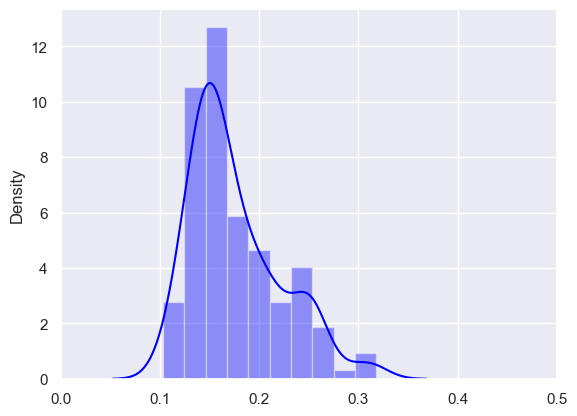

In [259]:
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
scored = np.mean(np.abs(x_test-decode_images), axis = 1)
print(np.max(scored))
plt.figure()
sns.distplot(scored,
             bins = 10,
             kde= True,
            color = 'blue')
plt.xlim([0.0,.5])

In [260]:
img = cv2.imread('./dataset/test/test_SP5_014.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (100,100))
test = []
test.append(img)
images_array = np.array([np.array(image) for image in test])


1/1 [==============================] - 0s 15ms/step


(1, 10000)
(1, 10000)
(1, 100, 100)


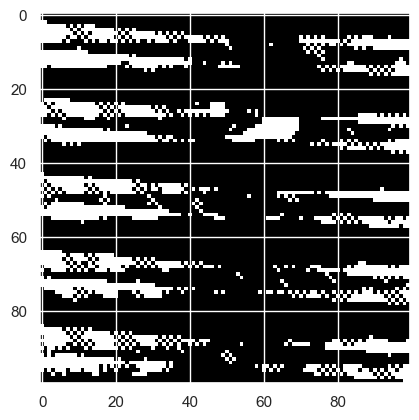

In [261]:
test = images_array.astype('float32') / 255.
test = test.reshape((test.shape[0], -1))
decoder_images = autoencoder.predict(test)

print(test.shape)
print(decoder_images.shape)
ab = np.abs(test-decoder_images)
imgs = np.array(ab)
# 深拷贝ab
imgs = np.copy(ab)
imgs[ab > 0.32] = 1
imgs[ab <= 0.32] = 0
imgs = imgs.reshape((imgs.shape[0], 100, 100))
print(imgs.shape)
plt.imshow(imgs[0], cmap='gray')


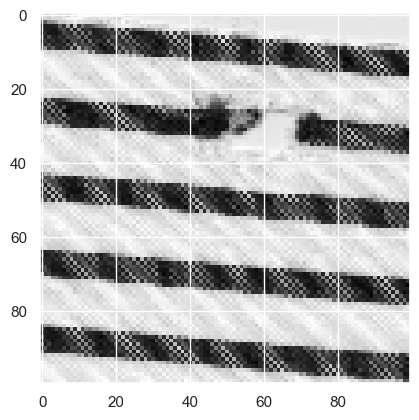

In [262]:
plt.imshow(test[0].reshape(100,100), cmap='gray')

(10000,)


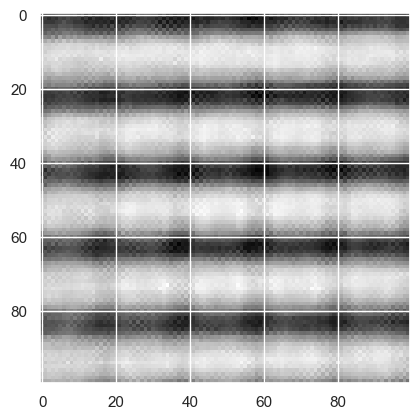

In [263]:
print(decoder_images[0].shape)
plt.imshow(decode_images[0].reshape(100,100), cmap='gray')

0.35470536


C:\Users\11516\AppData\Local\Temp\ipykernel_7800\1078208776.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored,


(0.0, 0.5)

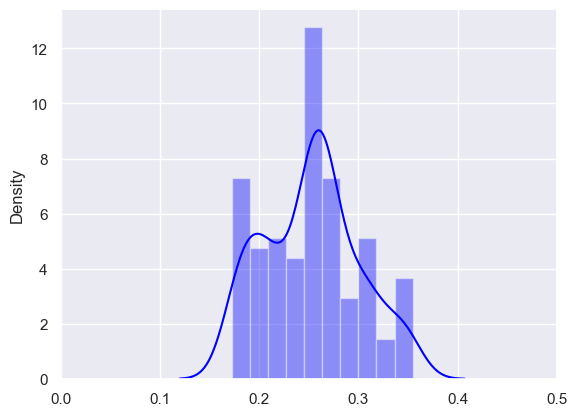

In [264]:
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
scored = np.mean(np.abs(test-decode_images), axis = 1)
print(np.max(scored))

plt.figure()
sns.distplot(scored,
             bins = 10,
             kde= True,
            color = 'blue')
plt.xlim([0.0,.5])